# Imports

In [1]:
import os
import datasets
import PIL
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from ultralytics import settings
settings.update({"mlflow": True})

/home/bob1ch/Рабочий стол/DNS_тестовое/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NUM_CLASSES = 4
LABELS = ['dropped spike', 'enemy', 'planted spike', 'teammate']
IMG_SIZE = (416, 416)
DATASET_DIR = 'datasets/dataset_notebook'
MODELS_DIR = 'models/'

# Dataset

In [3]:
dataset = datasets.load_dataset("keremberke/valorant-object-detection", "full")

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6927
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1983
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 988
    })
})

In [5]:
folders = ['train', 'val', 'test']

for folder in folders:
    os.makedirs(f"{DATASET_DIR}/{folder}/images", exist_ok=True)
    os.makedirs(f"{DATASET_DIR}/{folder}/labels", exist_ok=True)

def save_yolo_format(dataset_split, split_name):
    
    for sample in dataset_split:
        image = sample['image']
        image_id = sample['image_id']
        image_width = sample['width']
        image_height = sample['height']
        
        image_path = f"{DATASET_DIR}/{split_name}/images/{image_id}.jpg"
        image.save(image_path)

        with open(f"{DATASET_DIR}/{split_name}/labels/{image_id}.txt", "w") as f:
            for obj in sample['objects']['bbox']:
                category = sample['objects']['category'][0]
                x, y, bbox_width, bbox_height = obj

                x_center = (x + bbox_width / 2) / image_width
                y_center = (y + bbox_height / 2) / image_height
                width_normalized = bbox_width / image_width
                height_normalized = bbox_height / image_height

                f.write(f"{category} {x_center} {y_center} {width_normalized} {height_normalized}\n")

save_yolo_format(dataset['train'], 'train')
save_yolo_format(dataset['validation'], 'val')
save_yolo_format(dataset['test'], 'test')

config = f"""
train: {os.path.abspath(DATASET_DIR)}/train/images
val: {os.path.abspath(DATASET_DIR)}/val/images
test: {os.path.abspath(DATASET_DIR)}/test/images

nc: {NUM_CLASSES}
names: {LABELS}
"""

with open(f"{DATASET_DIR}/dataset.yaml", "w") as yaml_file:
    yaml_file.write(config)


# Analysis

In [6]:
def count_images_objects_classes(dataset):

    classes_count_dict = {k:0 for k in range(NUM_CLASSES)}
    objects_count = 0 #на 1 изображении может быть несколько объектов
    
    for sample in dataset:
        objects_count += len(sample['objects']['category'])
        for cat in sample['objects']['category']:
            classes_count_dict[cat] += 1

    return len(dataset), objects_count, classes_count_dict

In [7]:
train_counts = count_images_objects_classes(dataset['train'])
val_counts = count_images_objects_classes(dataset['validation'])
test_counts = count_images_objects_classes(dataset['test'])
                                           
print(f"Train: {train_counts[0]} images, {train_counts[1]} objects, {train_counts[2]} classes")
print(f"Train: {val_counts[0]} images, {val_counts[1]} objects, {val_counts[2]} classes")
print(f"Train: {test_counts[0]} images, {test_counts[1]} objects, {test_counts[2]} classes")

Train: 6927 images, 7184 objects, {0: 396, 1: 3729, 2: 461, 3: 2598} classes
Train: 1983 images, 2072 objects, {0: 117, 1: 1047, 2: 162, 3: 746} classes
Train: 988 images, 1025 objects, {0: 62, 1: 520, 2: 72, 3: 371} classes


In [8]:
def plot_class_distribution(counts: dict[int, int], name_split: str, ax):
    ax.bar(counts.keys(), counts.values(), color=['red', 'green', 'blue', 'orange'])
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of objects')
    ax.set_title(f'Class distribution of {name_split}')

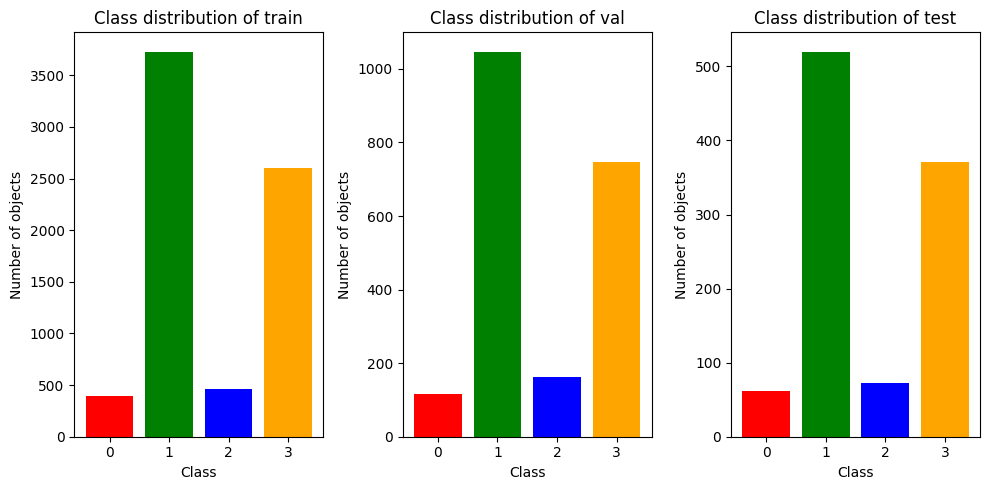

In [9]:
fig, axs = plt.subplots(*(1, 3), figsize = (10, 5))
splits = folders.copy() #выше сплиты были заданы как имена папок
for counts, split, ax in zip([train_counts, val_counts, test_counts], splits, axs.flatten()):
    plot_class_distribution(counts[2], split, ax)
plt.tight_layout()

Распределение классов между сплитами хорошее, а вот дисбаланс классов не нравится

In [10]:
def bboxes_and_pos(dataset):
    bbox_w, bbox_h = [], []
    x, y = [], []
    
    for sample in dataset:
        for bbox in sample['objects']['bbox']:
            x_cur, y_cur, w_cur, h_cur = bbox
            x.append(int(x_cur))
            y.append(int(y_cur))
            bbox_w.append(w_cur)
            bbox_h.append(h_cur)
    return x, y, bbox_w, bbox_h

In [11]:
train_bboxes = bboxes_and_pos(dataset['train'])
val_bboxes = bboxes_and_pos(dataset['validation'])
test_bboxes = bboxes_and_pos(dataset['test'])

In [12]:
def plot_bboxes_distribution(ax, bboxes, split, type_, bins):
    ax.hist(bboxes, bins)
    ax.set_xlabel('bbox size')
    ax.set_ylabel('number of bbox')
    ax.set_title(f'{split} distribution of {type_}')

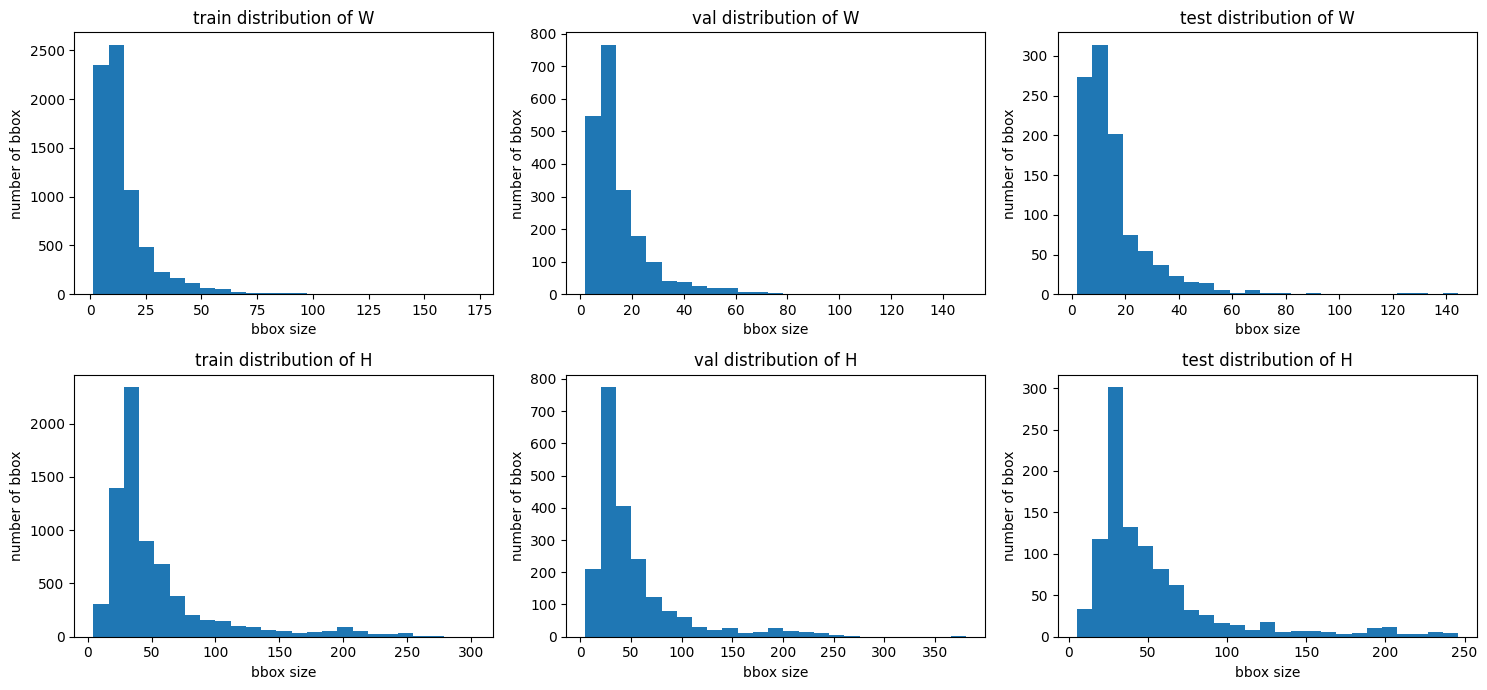

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
#все эти странные выражения можно было бы заменить декартовым произведением
split = folders.copy() * 2 
types = ['W']*3 + ['H']*3
type2id = {'W': 2, 'H': 3}
bboxes = [train_bboxes, val_bboxes, test_bboxes]*2

for ax, bbxs, split, type_ in zip(axs.flatten(), bboxes, split, types):
    plot_bboxes_distribution(ax, bbxs[type2id[type_]], split, type_, 25)

plt.tight_layout()

По этим данным можно понять, что ббоксы у нас не слишком большие и преимущсетвенно прямоуглольные (moda(H) > moda(W))

Также форма распределения размеров ббоксов между трейн/тест/сплит практически одинаковая

In [14]:
heat_map = np.zeros(IMG_SIZE)

In [15]:
np.add.at(heat_map, (train_bboxes[0], train_bboxes[1]), 1)

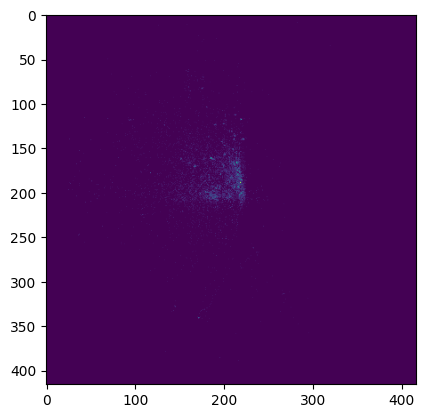

In [16]:
plt.imshow(heat_map)

# YOLO

In [ ]:
os.makedirs(MODELS_DIR, exist_ok=True)
model = YOLO(os.path.join(MODELS_DIR, "yolo11n.pt"))
results = model.train(data=os.path.join(DATASET_DIR, 'dataset.yaml'), epochs=10)

100%|█████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:01<00:00, 3.13MB/s]


New https://pypi.org/project/ultralytics/8.3.26 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.24 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050, 7870MiB)
engine/trainer: task=detect, mode=train, model=models/yolo11n.pt, data=datasets/dataset_notebook/dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

100%|█████████████████████████████████████████████████████████████████████████| 5.35M/5.35M [00:01<00:00, 3.77MB/s]


AMP: checks passed ✅


train: Scanning /home/bob1ch/Рабочий стол/DNS_тестовое/datasets/dataset_notebook/train/labels... 6927 images, 1 bac


train: New cache created: /home/bob1ch/Рабочий стол/DNS_тестовое/datasets/dataset_notebook/train/labels.cache


val: Scanning /home/bob1ch/Рабочий стол/DNS_тестовое/datasets/dataset_notebook/val/labels... 1983 images, 1 backgro

val: New cache created: /home/bob1ch/Рабочий стол/DNS_тестовое/datasets/dataset_notebook/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2024/10/31 23:55:12 INFO mlflow.tracking.fluent: Experiment with name '/Shared/Ultralytics' does not exist. Creating a new experiment.


MLflow: logging run_id(510d2db2beaf4a4494b3a2d29be46c10) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.34G      1.548      3.189      1.139         15        640: 100%|██████████| 433/433 [01:08<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0


                   all       1983       2072      0.778      0.671      0.766      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.37G      1.479      1.482      1.104         16        640: 100%|██████████| 433/433 [01:03<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0

                   all       1983       2072      0.855      0.743      0.864      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.38G      1.441      1.048      1.087         16        640: 100%|██████████| 433/433 [01:02<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0

                   all       1983       2072      0.857      0.825      0.881       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.38G      1.379      0.906      1.059         16        640: 100%|██████████| 433/433 [01:04<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0

                   all       1983       2072       0.83      0.826      0.896      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.38G      1.312     0.8006      1.029         16        640: 100%|██████████| 433/433 [01:04<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0

                   all       1983       2072      0.924        0.9      0.934      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.36G      1.267     0.7515      1.004         16        640: 100%|██████████| 433/433 [01:04<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0

                   all       1983       2072      0.933      0.904      0.941      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.37G      1.238     0.6998     0.9883         15        640: 100%|██████████| 433/433 [01:04<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0

                   all       1983       2072      0.955      0.943      0.967      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.37G      1.188     0.6513      0.972         15        640: 100%|██████████| 433/433 [01:04<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0

                   all       1983       2072      0.949      0.941      0.964      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.38G      1.144     0.6132      0.959         16        640: 100%|██████████| 433/433 [01:04<00:0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 62/62 [0

                   all       1983       2072      0.959      0.963      0.979      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.36G       1.12     0.5889     0.9428         17        640:  49%|████▉     | 214/433 [00:31<00:3